In [2]:
from collections import defaultdict as ddict, OrderedDict as odict
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bayes_opt import BayesianOptimization
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Descriptors import MolWt
from sklearn.ensemble import RandomForestRegressor
import sklearn
from rdkit.Chem.rdmolops import GetFormalCharge
import torch
import deepchem as dc
import statsmodels.api as sm

import imp

from joypy import joyplot

RDKit WARNING: [15:34:49] Enabling RDKit 2019.09.3 jupyter extensions


In [150]:
data = pd.read_csv('data/full_pka_data.csv')
solute = data['Solute SMILES'].tolist()
solvent = data['Solvent SMILES'].tolist()
pka = data['pKa (avg)'].tolist()
size = len(solute)
print(size)
sol_solv_pairs = [(solute[x],solvent[x]) for x in range(size)]

3222


In [148]:
i=0
for sol in solute:
    mol = Chem.MolFromSmiles(sol)
    [a.SetAtomMapNum(0) for a in mol.GetAtoms()]
    solute[i] = Chem.MolToSmiles(mol)
    print(Chem.MolToSmiles(mol))
    i+=1

C1CN=C2NCCC[NH+]2C1
c1ccc([NH2+]c2ccccc2)cc1
N#CC1=C(C#N)CC=C1
C[NH+](C)c1c(Cl)cc([N+](=O)[O-])cc1Cl
C[N+]1(CC[NH+](c2ccccc2)c2ccccc2)CCCCC1
C[C@H](O)C(=O)O
[NH3+]CCc1ccccc1
CC(C)C(c1ccc([N+](=O)[O-])cc1)[N+](=O)[O-]
Cc1ccccc1[NH+](C)C
CCOP(=O)(OCC)OCC[NH+](C)C
O=C(O)COc1nc(Cl)c(Cl)cc1Cl
c1ccc(C[NH2+]C(CC2CCCCC2)CC2CCCCC2)cc1
C1CN=C2CCC[NH+]2C1
[NH3+]c1cccc2c1Cc1ccccc1-2
[O-][Cl+3]([O-])([O-])O
CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=O)N2[C@H]1C(=O)O
O=C(c1ccccc1)N(O)c1ccccc1
COc1cc2nc(-c3ccc(N4CC[NH+](C)CC4)cc3)nc(NCCN3CCOCC3)c2cc1OC
C[NH+](C)c1ccc(C=O)cc1
Cc1ccc(C[NH3+])cc1
[NH3+]c1ccc(CC(=O)O)cc1
Oc1c(Cl)cccc1Cl
O=C(O)CCSCc1ccccc1
c1ccc(CCC[NH2+]C(Cc2ccccc2)Cc2ccccc2)cc1
Cc1cc[nH+]c(N)n1
COc1cccc(C[NH3+])c1OC
O=P1(O)Oc2c(-c3cc4ccccc4c4ccccc34)cc3c(c2-c2c4c(cc(-c5cc6ccccc6c6ccccc56)c2O1)CCCC4)CCCC3
CC[NH2+]CC
Cl
NC1=[NH+][C@H](c2ccc(F)cc2)Nc2cccc(F)c21
O=CNO
Nc1cccc[nH+]1
Cc1cc(C)cc(O)c1
Cc1ccc(S(=O)(=O)[N-]C(=O)N2CCC([NH+]3CCC(Oc4ccc(Cl)c(C)c4Cl)CC3)CC2)cc1
CC1(C)C[NH2+]1
C[N@

In [151]:
#sizes
sol_set = list(set(solute))
solv_set = list(set(solvent))
print('# of unique solutes: ', len(sol_set))
print('# of unique solvents: ', len(solv_set))

# of unique solutes:  2761
# of unique solvents:  6


In [152]:
print(solv_set)
solvent_dielectric_key = [46.68,10.36,36.71,80.1,7.58,37.5]
solvent_dielectrics = [solvent_dielectric_key[solv_set.index(solv)] for solv in solvent]
solvent_polarity_key = [4.1,1.83,3.86,1.87,1.75,3.44]
solvent_polarities = [solvent_polarity_key[solv_set.index(solv)] for solv in solvent]

['CS(=O)C', 'C(CCl)Cl', 'CN(C)C=O', 'O', 'C1CCOC1', 'CC#N']


In [45]:
print(solute_s[1],solvent_s[1],pka_s[1])

C1=C[NH2+]C=N1 C1CCOC1 1.4


In [153]:
#solvent sizes
print('# of solutes in each solvent:')
for solv in solv_set:
    print(solv,':',solvent.count(solv))

# of solutes in each solvent:
CS(=O)C : 130
C(CCl)Cl : 88
CN(C)C=O : 20
O : 2519
C1CCOC1 : 65
CC#N : 400


# of solutes in CS(=O)C : 130


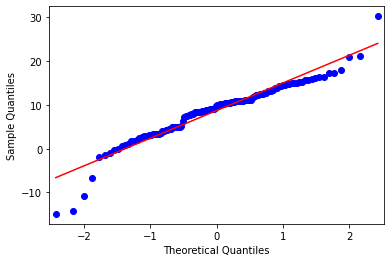

shapiro: 1.7842326997197233e-05
# of solutes in C(CCl)Cl : 88


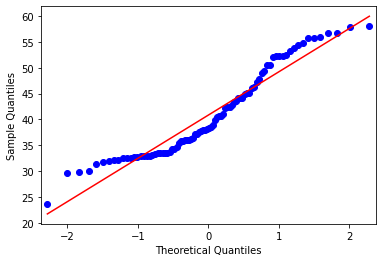

shapiro: 9.448809578316286e-05
# of solutes in CN(C)C=O : 20


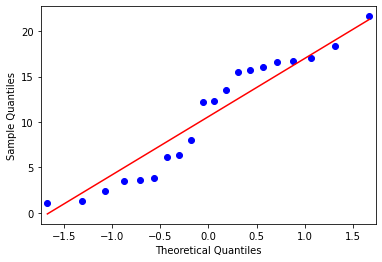

shapiro: 0.06562642008066177
# of solutes in O : 2519


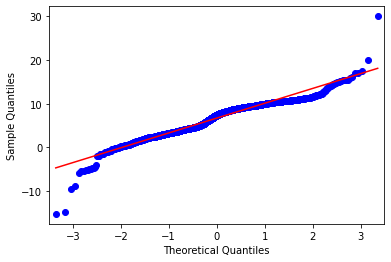

shapiro: 6.600642920418668e-28
# of solutes in C1CCOC1 : 65


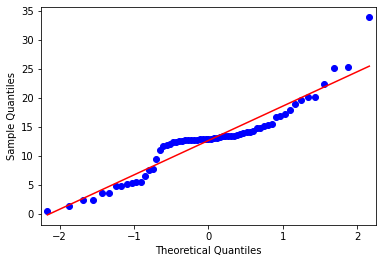

shapiro: 0.0006868900381959975
# of solutes in CC#N : 400


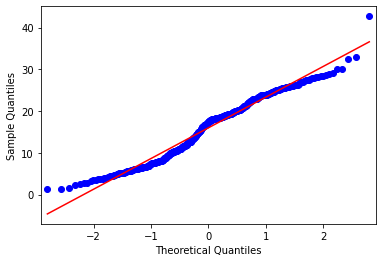

shapiro: 2.9742560059276e-07


In [154]:
#solvent distributions

import statsmodels.api as sm
from scipy.stats import norm
import pylab
from scipy.stats import shapiro

for solv in solv_set:
    print('# of solutes in',solv,':',solvent.count(solv))
    ids = [i for i,x in enumerate(solvent) if x == solv]
    pkas = np.array([pka[x] for x in ids])
    sm.qqplot(pkas, line='s')
    pylab.show()
    print('shapiro:',shapiro(pkas)[1])
    
#all are not normally distributed, except for CN(C)C=O

In [155]:
#solutes with multiple solvents
multisolv_sol = ddict(list)
for sol in sol_set:
    indices = [i for i,x in enumerate(solute) if x == sol]
    pkas = [pka[i] for i in indices]
    solvents = [solvent[i] for i in indices]
    multisolv_sol[sol].append(solvents)
    multisolv_sol[sol].append(pkas)
    
for x in range(1,7):
    i=0
    for sol in sol_set:
        if len(multisolv_sol[sol][0])==x:
            i+=1
    print(str(i)+" solutes with "+str(x)+" solvents")

2498 solutes with 1 solvents
153 solutes with 2 solvents
30 solutes with 3 solvents
73 solutes with 4 solvents
6 solutes with 5 solvents
1 solutes with 6 solvents


In [46]:
#solvent dielectric
multisolv_sol = ddict(list)
for sol in sol_set:
    indices = [i for i,x in enumerate(solute) if x == sol]
    pkas = [pka[i] for i in indices]
    solvents = [solvent_dielectrics[i] for i in indices]
    solvents, pkas = (list(t) for t in zip(*sorted(zip(solvents, pkas))))
    multisolv_sol[sol].append(solvents)
    multisolv_sol[sol].append(pkas)

In [84]:
#solvent polarity
multisolv_sol = ddict(list)
for sol in sol_set:
    indices = [i for i,x in enumerate(solute) if x == sol]
    pkas = [pka[i] for i in indices]
    solvents = [solvent_polarities[i] for i in indices]
    solvents, pkas = (list(t) for t in zip(*sorted(zip(solvents, pkas))))
    multisolv_sol[sol].append(solvents)
    multisolv_sol[sol].append(pkas)

In [47]:
multisolv_sol[solute[0]]

[[7.58, 37.5, 46.68, 80.1], [20.2, 26.025, 15.3, 15.2]]

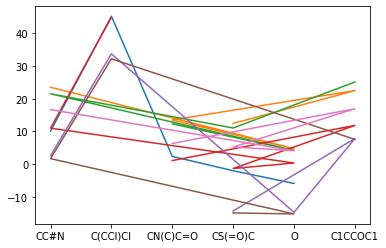

In [89]:
for sol in sol_set:
    if len(multisolv_sol[sol][0])>4:
        plt.plot(*multisolv_sol[sol])
plt.show()

In [156]:
#solvent intersections
multisolv_sol = ddict(list)
for sol in sol_set:
    indices = [i for i,x in enumerate(solute) if x == sol]
    pkas = [pka[i] for i in indices]
    solvents = [solvent[i] for i in indices]
    multisolv_sol[sol].append(solvents)
    multisolv_sol[sol].append(pkas)

solv_n = ddict(list)
for solv1 in solv_set:
    solv_n['solvents'].append(solv1)
    for solv2 in solv_set:
        if solv1 == solv2:
            i='x'
        else:
            i=0
            for sol in sol_set:
                solvs = multisolv_sol[sol][0]
                pkas = multisolv_sol[sol][1]
                if solv1 in solvs and solv2 in solvs:
                    i+=1
        solv_n[solv2].append(i)
        
solv_n = pd.DataFrame(solv_n)
print(solv_n)

   solvents CS(=O)C C(CCl)Cl CN(C)C=O    O C1CCOC1 CC#N
0   CS(=O)C       x       19       15   97      63  130
1  C(CCl)Cl      19        x        2   12       3   59
2  CN(C)C=O      15        2        x   16       4   20
3         O      97       12       16    x      64  187
4   C1CCOC1      63        3        4   64       x   65
5      CC#N     130       59       20  187      65    x


number of solutes: 19


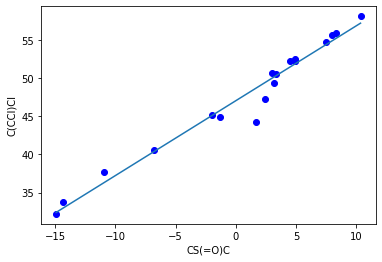

number of solutes: 15


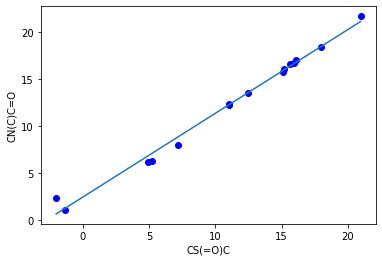

number of solutes: 97


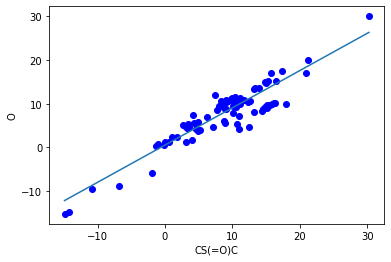

number of solutes: 63


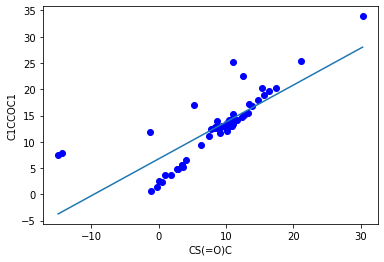

number of solutes: 130


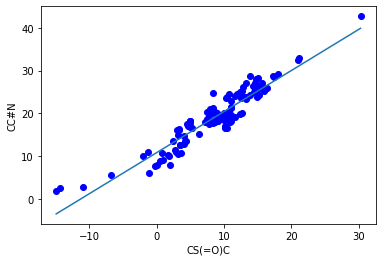

number of solutes: 2


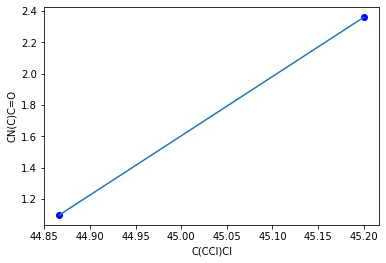

number of solutes: 12


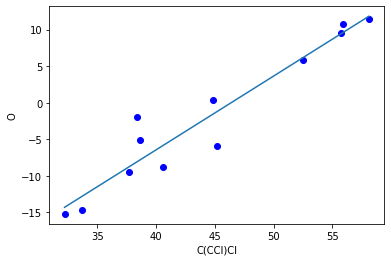

number of solutes: 3


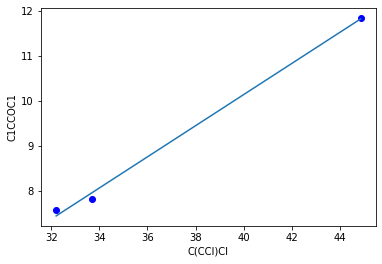

number of solutes: 59


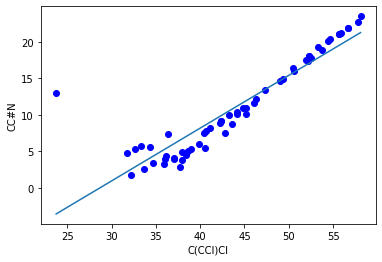

number of solutes: 16


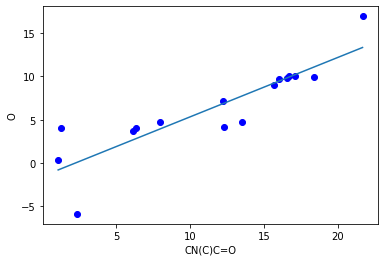

number of solutes: 4


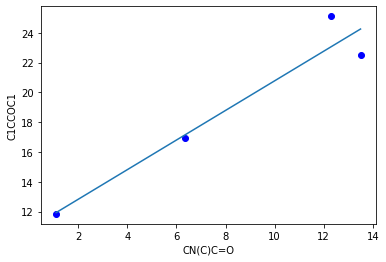

number of solutes: 20


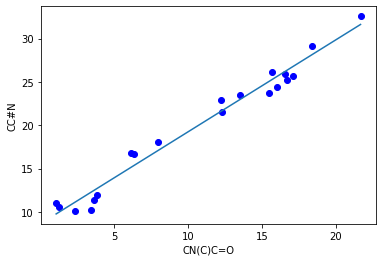

number of solutes: 64


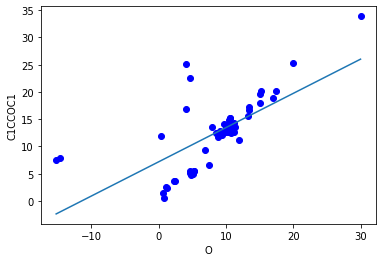

number of solutes: 187


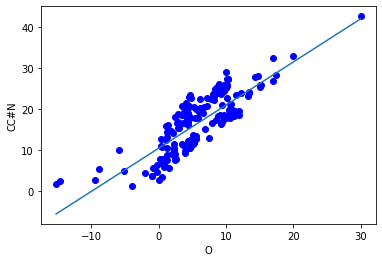

number of solutes: 65


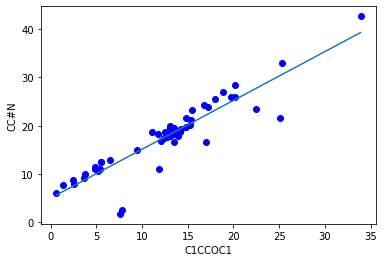

In [157]:
#double solvent
import itertools
pairs = list(itertools.combinations(solv_set, 2))
for (solv1, solv2) in pairs:
    solv1_list = []
    solv2_list = []

    multisolv_sol = ddict(list)
    for sol in sol_set:
        indices = [i for i,x in enumerate(solute) if x == sol]
        pkas = [pka[i] for i in indices]
        solvents = [solvent[i] for i in indices]
        multisolv_sol[sol].append(solvents)
        multisolv_sol[sol].append(pkas)

    for sol in sol_set:
        solvs = multisolv_sol[sol][0]
        pkas = multisolv_sol[sol][1]
        if solv1 in solvs and solv2 in solvs:
            solv1_list.append(pkas[solvs.index(solv1)])
            solv2_list.append(pkas[solvs.index(solv2)])
    print("number of solutes: "+str(len(solv1_list)))

    x = np.array(solv1_list)
    y = np.array(solv2_list)

    plt.plot(x, y, 'bo')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.xlabel(solv1)
    plt.ylabel(solv2)
    plt.show()

<Figure size 432x288 with 0 Axes>

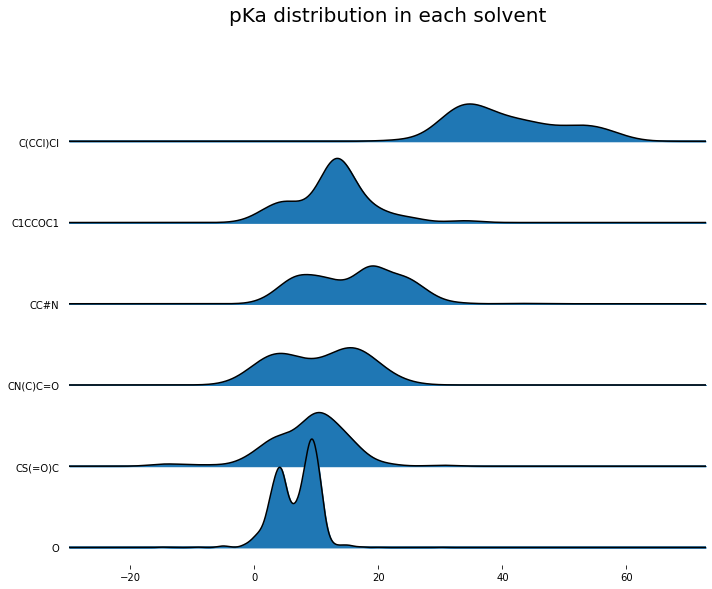

In [159]:
#pka spread in solvents
plt.figure()

joyplot(
    data=data[['pKa (avg)', 'Solvent SMILES']], 
    by='Solvent SMILES',
    figsize = (10,8)
)
plt.title('pKa distribution in each solvent', fontsize=20)
plt.show()

In [160]:
patt_list = [('any carbon','[#6]'),
             ('any nitrogen','[#7]'),
             ('any oxygen','[#8]'),
             ('any fluorine','[#9]'),
             ('any phosphorus','[#15]'),
             ('any sulfur','[#16]'),
             ('any chlorine','[#17]'),
             ('any bromine', '[#35]'),
             ('any iodine','[#53]'),
             ('any halide','[#6][F,Cl,Br,I]')]
matches = ddict(list)
for name, smart in patt_list:
    patt = Chem.MolFromSmarts(smart)
    for smile in sol_set:
        mol = Chem.MolFromSmiles(smile)
        if mol.HasSubstructMatch(patt):
            matches[name].append(smile)
    print(name+' matches: '+str(len(matches[name])))

any carbon matches: 2752
any nitrogen matches: 2178
any oxygen matches: 1881
any fluorine matches: 322
any phosphorus matches: 49
any sulfur matches: 453
any chlorine matches: 370
any bromine matches: 100
any iodine matches: 26
any halide matches: 773


In [217]:
patt_list = [('proton donor','[!H0;F,Cl,Br,I,N+,$([OH]-*=[!#6]),+]'),
             ('H-bond donor','[N,n,O;!H0]'),
             ('protonated amine','[NH+,NH2+,NH3+,nH+,nH2+]'),
             ('carboxylic acid','[CX3](=O)[OX2H1]'),
             ('amide','[NX3][CX3](=[OX1])[#6]'),
             ('ketone','[#6][CX3](=O)[#6]'),
             ('ether','[OD2]([#6])[#6]'),
             ('amine','[NX3;H2,H1;!$(NC=O)]'),
             ('nitrile','[NX1]#[CX2]'),
             ('nitro','[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]'),
             ('hydroxyl alcohol','[#6][OX2H]'),
             ('phenol','[OX2H][cX3]:[c]'),
             ('thiol','[#16X2H]'),
             ('phosphoric acid','[$(P(=[OX1])([$([OX2H]),$([OX1-]),$([OX2]P)])([$([OX2H]),$([OX1-]),$([OX2]P)])[$([OX2H]),$([OX1-]),$([OX2]P)]),$([P+]([OX1-])([$([OX2H]),$([OX1-]),$([OX2]P)])([$([OX2H]),$([OX1-]),$([OX2]P)])[$([OX2H]),$([OX1-]),$([OX2]P)])]')]
matches = ddict(list)
for name, smart in patt_list:
    patt = Chem.MolFromSmarts(smart)
    for smile in sol_set:
        mol = Chem.MolFromSmiles(smile)
        if mol.HasSubstructMatch(patt):
            matches[name].append(smile)
    print(name+' matches: '+str(len(matches[name])))

proton donor matches: 2004
H-bond donor matches: 2640
protonated amine matches: 1541
carboxylic acid matches: 469
amide matches: 184
ketone matches: 80
ether matches: 524
amine matches: 337
nitrile matches: 133
nitro matches: 253
hydroxyl alcohol matches: 1091
phenol matches: 414
thiol matches: 72
phosphoric acid matches: 12


In [214]:
patt_lists = ddict(list)
#solutes = [x for x in sol_set]
acid_list = [#('plus','[+]'),
            ('protonated amine','[N+,NH+,NH2+,NH3+,n+,nH+,nH2+,nH3+,NX3+,NX2+,N@H+,+]'),
             ('carboxylic acid','[CX3](=O)[OX2H1]'),
             ('phosphoric acid','[$(P(=[OX1])([$([OX2H]),$([OX1-]),$([OX2]P)])([$([OX2H]),$([OX1-]),$([OX2]P)])[$([OX2H]),$([OX1-]),$([OX2]P)]),$([P+]([OX1-])([$([OX2H]),$([OX1-]),$([OX2]P)])([$([OX2H]),$([OX1-]),$([OX2]P)])[$([OX2H]),$([OX1-]),$([OX2]P)])]'),
             ('phenol','[OX2H][cX3]:[c]'),
             ('hydroxyl alcohol','[#6][OX2H]'),
             ('thiol','[#16X2H]'),
             ('halogen','[HF,HCl,HBr,HI]')]

for name, smart in acid_list:
    patt = Chem.MolFromSmarts(smart)
    for smile in solutes:
        mol = Chem.MolFromSmiles(smile)
        if mol.HasSubstructMatch(patt):
            patt_lists[name].append(smile)
            solutes.remove(smile)
    print(name+' matches: '+str(len(patt_lists[name])))

protonated amine matches: 0
carboxylic acid matches: 274
phosphoric acid matches: 9
phenol matches: 208
hydroxyl alcohol matches: 159
thiol matches: 48
halogen matches: 3


In [213]:
patt_lists = ddict(list)
solutes = [x for x in sol_set]
smart_list = ['[N+]','[NH+]','[NH2+]','[NH3+]','[n+]','[nH+]','[nH2+]','[nH3+]','[NX3+]','[NX2+]','[N@H+]','[+]']

for smart in smart_list:
    patt = Chem.MolFromSmarts(smart)
    for smile in solutes:
        mol = Chem.MolFromSmiles(smile)
        if mol.HasSubstructMatch(patt):
            patt_lists[smart].append(smile)
            solutes.remove(smile)
    print(smart+' matches: '+str(len(patt_lists[smart])))

[N+] matches: 1000
[NH+] matches: 184
[NH2+] matches: 106
[NH3+] matches: 168
[n+] matches: 130
[nH+] matches: 15
[nH2+] matches: 0
[nH3+] matches: 0
[NX3+] matches: 61
[NX2+] matches: 1
[N@H+] matches: 15
[+] matches: 37


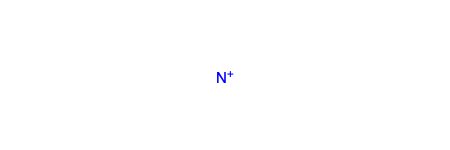

In [208]:
Chem.MolFromSmarts('[N+]')

In [196]:
mol = Chem.MolFromSmiles('CC[NH+](CC)CCOC(=O)[C@@H](Cc1cccc2ccccc12)C[C@@H]1CCCO1')
patt = Chem.MolFromSmarts('[NH+,NH2+,NH3+,nH+,nH2+,nH3+,NX3+,NX2+,N@H+,+]')
mol.HasSubstructMatch(patt)

True

['COc1ccc(S(=O)(=O)NC(=O)N2CCC(N3CCC(Oc4ccc(Cl)c(Cl)c4)CC3)CC2)cc1', 'O=C1c2ccccc2C(=O)c2cc(S(=O)(=O)O)ccc21', 'O=S(=O)(NS(=O)(=O)c1c(F)c(F)c(F)c(F)c1F)c1ccc(Cl)cc1', 'N#CC(C#N)=C(Br)C(C#N)C#N', 'O=S(=O)(NS(=O)(=O)C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F', 'O=S(=O)(N=C(NS(=O)(=O)C(F)(F)F)c1ccccc1)C(F)(F)F', 'Cc1ccc(C(=O)NO)cc1', 'CS(=O)(=O)O', 'O=C(c1cccc(C(F)(F)F)c1)N(O)c1ccccc1', 'Cc1c(F)c(F)c(C(C#N)c2ccccc2)c(F)c1F', 'Oc1ccc2cncnc2c1', 'CCCC(=O)OO', 'OC1(c2c(F)c(F)c(F)c(F)c2F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C1(F)F', 'COC(=O)c1cccc(C)c1S(=O)(=O)NC(=O)Nc1nc(OCC(F)(F)F)nc(N(C)C)n1', 'O=S(=O)(Nc1ccccc1)c1ccc(Cl)cc1', 'CC#Cc1c(C)nc(O)nc1C', 'N#CC(c1ccccc1)c1c(F)c(F)c(F)c(F)c1F', 'O=C([O-])CCCCC(=O)O', 'COc1nc(C)nc(NC(=O)NS(=O)(=O)c2ccccc2Cl)n1', 'COC(=O)c1ccccc1S(=O)(=O)NC(=O)Nc1nc(OC(F)F)cc(OC(F)F)n1', 'C=C(C)C(=O)O', 'CCOC(=O)C(C#N)c1c(F)c(F)c(Cl)c(F)c1F', 'Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1', 'O=C(NO)c1ccc(Cl)cc1', 'CCOC(=O)N1CCC(c2cc(=O)n(-c3ccccc3)[nH]2)CC1', 'O=S1(=O)NS(=O)(=O)c2c(-c3cc(C(F)(F)F)cc(

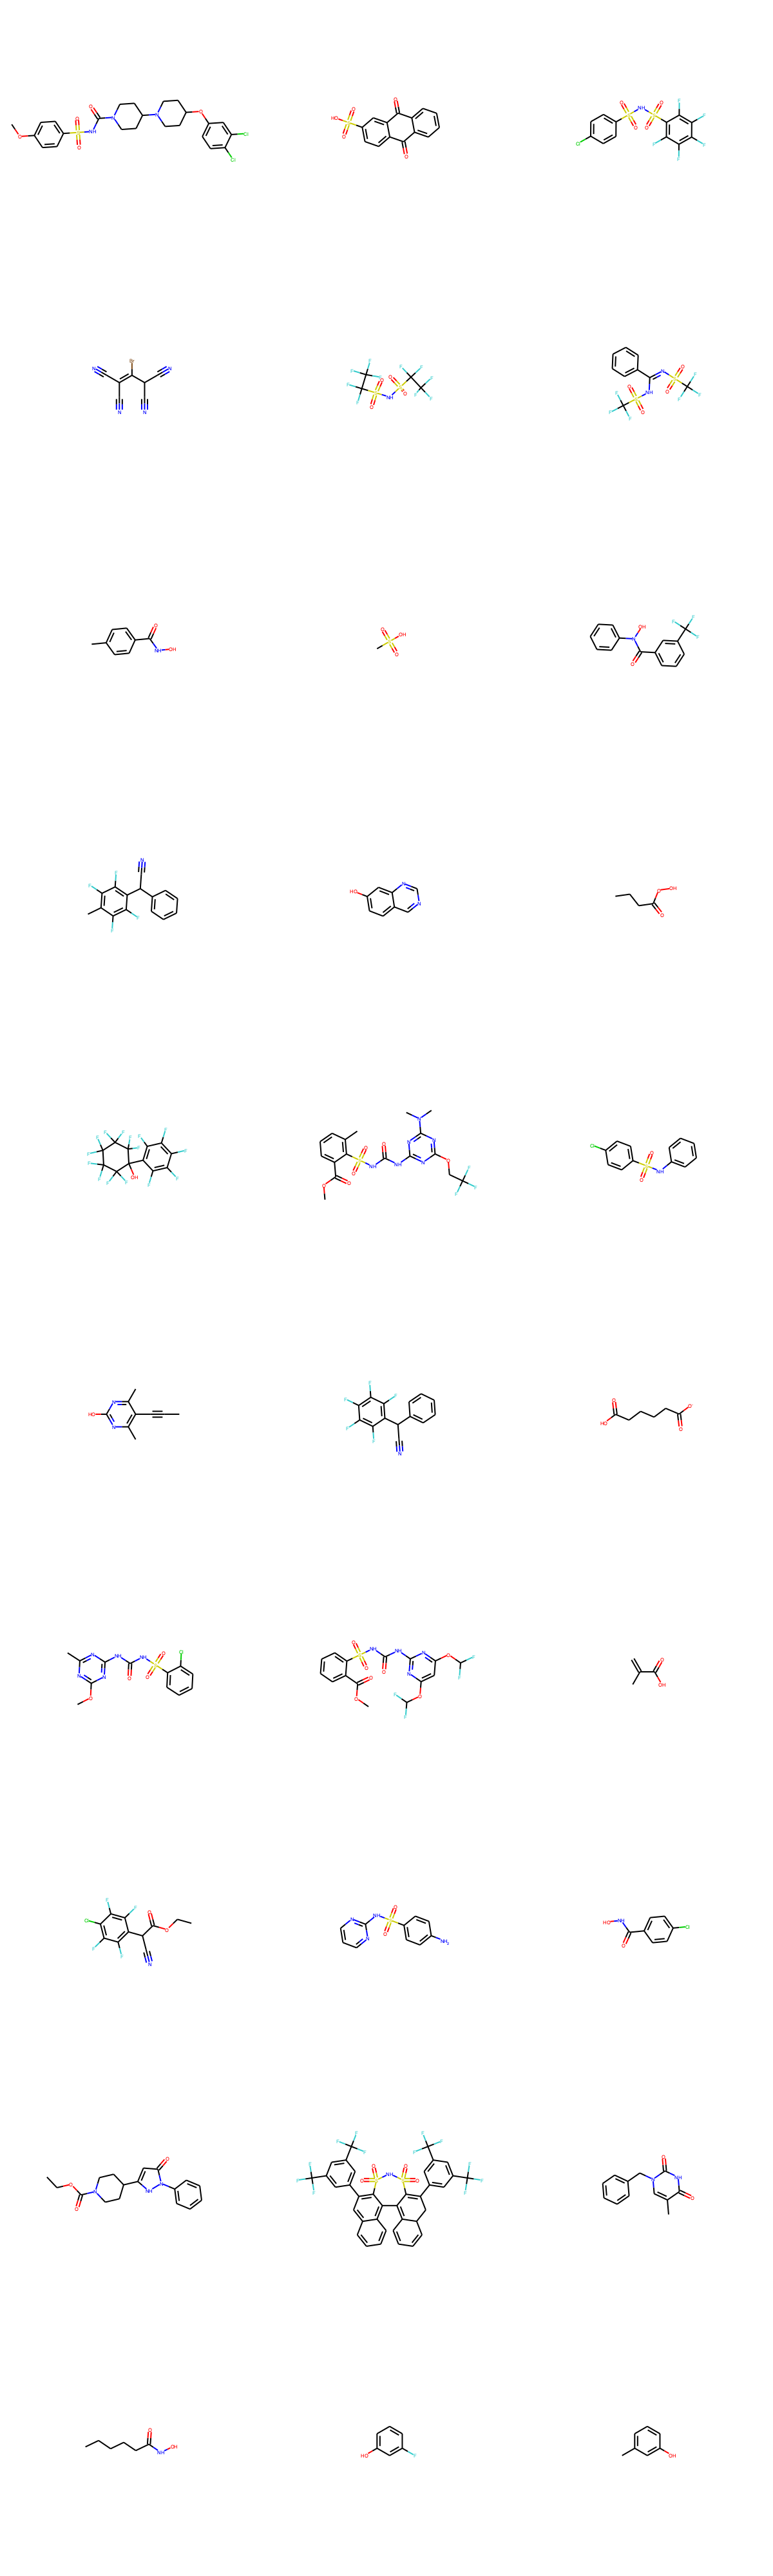

In [215]:
from rdkit import Chem
from rdkit.Chem import Draw, MolToSmiles
print([solutes[x] for x in range(10,40)])
Draw.MolsToGridImage([Chem.MolFromSmiles(solutes[x]) for x in range(10,40)], subImgSize=[400,400])

In [111]:
patt_list = [('aromatic carbon','[$([cX3](:*):*),$([cX2+](:*):*)]')]
matches = ddict(list)
for name, smart in patt_list:
    patt = Chem.MolFromSmarts(smart)
    for smile in sol_set:
        mol = Chem.MolFromSmiles(smile)
        if mol.HasSubstructMatch(patt):
            matches[name].append(smile)
    print(name+' matches: '+str(len(matches[name])))

aromatic carbon matches: 2213


In [98]:
featuriser = dc.feat.RDKitDescriptors()
sol = featuriser.featurize('CC')
featuriser.descriptors

['MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA8',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_V

In [99]:
rdkit_list = ['HeavyAtomCount',
 'NHOHCount',
 'NOCount',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRotatableBonds',
 'NumSaturatedCarbocycles',
 'NumSaturatedHeterocycles',
 'NumSaturatedRings',
 'RingCount',
 'MolLogP',
 'MolMR',
 'fr_Al_COO',
 'fr_Al_OH',
 'fr_Al_OH_noTert',
 'fr_ArN',
 'fr_Ar_COO',
 'fr_Ar_N',
 'fr_Ar_NH',
 'fr_Ar_OH',
 'fr_COO',
 'fr_COO2',
 'fr_C_O',
 'fr_C_O_noCOO',
 'fr_C_S',
 'fr_HOCCN',
 'fr_Imine',
 'fr_NH0',
 'fr_NH1',
 'fr_NH2',
 'fr_N_O',
 'fr_Ndealkylation1',
 'fr_Ndealkylation2',
 'fr_Nhpyrrole',
 'fr_SH',
 'fr_aldehyde',
 'fr_alkyl_carbamate',
 'fr_alkyl_halide',
 'fr_allylic_oxid',
 'fr_amide',
 'fr_amidine',
 'fr_aniline',
 'fr_aryl_methyl',
 'fr_azide',
 'fr_azo',
 'fr_barbitur',
 'fr_benzene',
 'fr_benzodiazepine',
 'fr_bicyclic',
 'fr_diazo',
 'fr_dihydropyridine',
 'fr_epoxide',
 'fr_ester',
 'fr_ether',
 'fr_furan',
 'fr_guanido',
 'fr_halogen',
 'fr_hdrzine',
 'fr_hdrzone',
 'fr_imidazole',
 'fr_imide',
 'fr_isocyan',
 'fr_isothiocyan',
 'fr_ketone',
 'fr_ketone_Topliss',
 'fr_lactam',
 'fr_lactone',
 'fr_methoxy',
 'fr_morpholine',
 'fr_nitrile',
 'fr_nitro',
 'fr_nitro_arom',
 'fr_nitro_arom_nonortho',
 'fr_nitroso',
 'fr_oxazole',
 'fr_oxime',
 'fr_para_hydroxylation',
 'fr_phenol',
 'fr_phenol_noOrthoHbond',
 'fr_phos_acid',
 'fr_phos_ester',
 'fr_piperdine',
 'fr_piperzine',
 'fr_priamide',
 'fr_prisulfonamd',
 'fr_pyridine',
 'fr_quatN',
 'fr_sulfide',
 'fr_sulfonamd',
 'fr_sulfone',
 'fr_term_acetylene',
 'fr_tetrazole',
 'fr_thiazole',
 'fr_thiocyan',
 'fr_thiophene',
 'fr_unbrch_alkane',
 'fr_urea']

In [100]:
desc_list = []
from rdkit.Chem import Descriptors
for descriptor, function in Descriptors.descList:
    if descriptor in rdkit_list:
        desc_list.append((descriptor, function))

In [69]:
features = ddict(list)
for desc_name, function in desc_list:
    for smile in sol_set:
        mol = Chem.MolFromSmiles(smile)
        feature = function(mol)
        features[desc_name].append(features)

sol_features = pd.DataFrame(features)
print(sol_features)

KeyboardInterrupt: 

In [101]:
featurizer = dc.feat.RDKitDescriptors()
sol_desc = featurizer.featurize(sol_set)

In [102]:
desc_list2 = featurizer.descriptors
[i for i,x in enumerate(desc_list2) if x == 'HeavyAtomCount']

[96]

In [103]:
sol_desc[0,300]

IndexError: index 300 is out of bounds for axis 1 with size 200

In [ ]:
features = ddict(list)
x = 96
for desc_name in desc_list2[96:]:
    for i in range(len(sol_set)):
        feature = sol_desc[i,x]
        features[desc_name].append(feature)
    x += 1

sol_features = pd.DataFrame(features)
print(sol_features)

In [ ]:
sol_features.to_csv('sol_features.csv')